# Lecture 2: Spark Dataframes

Spark SQL is the module within Spark dedicated to storing and processing structured datasets.

As we discussed at the beginning of this course, structured datasets are common in both scientific and non-scientific environments.

Structured data is typically represented using abstractions such as Pandas Dataframes or relational database tables.

In Spark, structured datasets are referred to as `Spark Dataframes`. 
A Spark Dataframe is built on top of the RDD low-level API, offering the same underlying logic concerning storing and partitioning data across multiple nodes, but also providing a richer set of functionalities and optimizations.


## Create and Start a Spark Session

In [1]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My dataframe spark application")\
    .config("spark.executor.memory", "512m")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/08 13:31:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
# create a spark context
sc = spark.sparkContext

# print its status
sc

<SparkContext master=spark://spark-master:7077 appName=My dataframe spark application>

## Creating a Spark DataFrame

A Spark DataFrame is a **distributed** collection of data grouped into named columns.

A Spark DataFrame is already very similar to the Pandas DataFrame API, and it can be created in a multitude of possible ways:

- Creating and appending a list of Spark Rows (Spark objects for records) with an *implicit* schema definition.
- Creating and appending a list of Python tuples with an *explicit* schema definition.
- Importing a Pandas DataFrame.
- From the results of a SQL query over a database or another DataFrame.
- From a collection of input files provided with a schema.

### Create a Spark DataFrame from a List of Rows

The Spark `Row` is the native Spark object that hosts the data of a record in a Spark DataFrame. It's equivalent to a Python tuple or a dictionary.

In [4]:
# create a spark dataframe from a list of Rows

# import the Row class from the pyspark.sql module
from pyspark.sql import Row
from datetime import date, datetime

# create a list of Row objects
#   each Row object contains a list of values
#   the list of values can be of different types
#   the list of values must be in the same order as the list of columns
df = spark.createDataFrame([
    Row(a=1, b=2., c='string1', d=date(2000, 1, 1), e=datetime(2000, 1, 1, 12, 0)),
    Row(a=2, b=3., c='string2', d=date(2000, 2, 1), e=datetime(2000, 1, 2, 12, 0)),
    Row(a=4, b=5., c='string3', d=date(2000, 3, 1), e=datetime(2000, 1, 3, 12, 0))
])

# print the spark dataframe
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

### Create a Spark DataFrame from a List of Tuples

PySpark allows passing records as a list of Python tuples. However, to allow Spark to interpret the tuple fields correctly, an **explicit schema definition** is required.

In [5]:
# create a spark dataframe from a list of Python tuples

# create a list of Python tuples
#   when creating the spark dataframe we must also 
#   pass the definition of the data types (i.e. the schema)
df = spark.createDataFrame([
    (1, 2., 'string1', date(2000, 1, 1), datetime(2000, 1, 1, 12, 0)),
    (2, 3., 'string2', date(2000, 2, 1), datetime(2000, 1, 2, 12, 0)),
    (3, 4., 'string3', date(2000, 3, 1), datetime(2000, 1, 3, 12, 0))
], schema='a long, b double, c string, d date, e timestamp')

# print the spark dataframe
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

### Create a Spark DataFrame from a Pandas DataFrame

PySpark can create a DataFrame starting from a Pandas DataFrame.

It should be noted that a Pandas DataFrame is meant to be stored in the memory of a local machine, while Spark is designed for hosting large datasets on storage/memory across multiple nodes.

Moving data that can be hosted on a local machine using Pandas to a remote cluster using Spark is typically not a very common use case.

In [6]:
# import pandas
import pandas as pd

# create an equivalent pandas dataframe
pandas_df = pd.DataFrame({
    'a': [1, 2, 3],
    'b': [2., 3., 4.],
    'c': ['string1', 'string2', 'string3'],
    'd': [date(2000, 1, 1), date(2000, 2, 1), date(2000, 3, 1)],
    'e': [datetime(2000, 1, 1, 12, 0), datetime(2000, 1, 2, 12, 0), datetime(2000, 1, 3, 12, 0)]
})

# create the spark dataframe from the pandas one
df = spark.createDataFrame(pandas_df)

# print the spark dataframe
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

As in the case of the creation of an RDD, the mere creation of a Spark DataFrame does not imply any work is submitted to the executors.

Whenever we ask Spark to retrieve something from the dataset, we instead trigger the execution of the jobs (as usual, subdivided into stages and tasks), starting from loading the dataset into the memory/storage of the remote cluster nodes.

To use a Spark DataFrame we have similar interfaces as in Pandas:
- `DataFrame.show()` to visualize its content (i.e. its state/instance)
- `DataFrame.printSchema()` to visualize the schema of the structured dataset

In [7]:
# print the first 10 rows (if available) of the dataframe
df.show()

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|
|  3|4.0|string3|2000-03-01|2000-01-03 12:00:00|
+---+---+-------+----------+-------------------+



In [8]:
# print the schema of the DataFrame
df.printSchema()

root
 |-- a: long (nullable = true)
 |-- b: double (nullable = true)
 |-- c: string (nullable = true)
 |-- d: date (nullable = true)
 |-- e: timestamp (nullable = true)



## Loading Structured Data

By default, Spark can create a DataFrame from data stored in many formats such as `csv`, `json`, `avro`, `parquet`, and many others listed [here](https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html).

If your dataset is stored in a format that Spark DataFrame cannot understand and interpret natively, it is always possible to first create an RDD as in the previous lecture and later convert the RDD into a DataFrame with the `toDF()` functionality.

Here we create some mock-up structured data in the form of a simple set of records with 2 features: `feature1` and `feature2`.

We can parallelize the creation of the `Rows` in Spark as if we were loading and "unpacking" or parsing data from a set of files.

In [9]:
# import numpy for random
import numpy as np

# mock-up function to load data from a file
def read_custom_data(file_name):
    # this is a placeholder code for some operation
    # you might have to perform when reading the files
    # for example, you might have to read the file line by line
    # and parse the lines into numerical values 
    custom_data = []
    # create 5 random events
    for _ in range(5):
        # each event is a pair of random numbers
        event = {
            'feature1': np.random.random(),
            'feature2': np.random.random()
        }
        # append each event to the list as a Spark Row object
        custom_data.append(Row(**event))
    return custom_data
    
# fake list of files to read
file_list = ['file1', 'file2']

# create an RDD parallelizing the read function on the file list
rdd = sc.parallelize(file_list)\
        .flatMap(read_custom_data)

# the RDD contains a list of Row objects, which can be converted 
# to a DataFrame by using the toDF() function
df = rdd.toDF()

The `df` object is now a Spark DataFrame containing a list of Rows.

However, Spark will always remember that the DataFrame is actually an RDD, and we can always operate on and retrieve the underlying RDD object from the DataFrame API simply by using `collect`.

In [10]:
# print the whole set of values in the RDD
rdd.collect()

[Row(feature1=0.26143489089166894, feature2=0.8880456247204658),
 Row(feature1=0.09531125307531463, feature2=0.8931729371224845),
 Row(feature1=0.9226263081316048, feature2=0.6870761085432311),
 Row(feature1=0.44058252640575024, feature2=0.37213479037162234),
 Row(feature1=0.48769377520221324, feature2=0.5290385069775219),
 Row(feature1=0.5673700356342822, feature2=0.8608625821231554),
 Row(feature1=0.8831170960413722, feature2=0.22844423750197673),
 Row(feature1=0.12015034035838101, feature2=0.4585666182649927),
 Row(feature1=0.22422572834449916, feature2=0.019256061883535125),
 Row(feature1=0.8034125754018512, feature2=0.40341622748801886)]

In [11]:
# perform the same operation on the dataframe
df.collect() 

[Row(feature1=0.5059381781901221, feature2=0.9820384913203631),
 Row(feature1=0.231065858363677, feature2=0.5377347127449856),
 Row(feature1=0.6880476166776767, feature2=0.5760215360144808),
 Row(feature1=0.3193001057075694, feature2=0.9811990771878889),
 Row(feature1=0.7999440198907637, feature2=0.5076625123320643),
 Row(feature1=0.5518643632958196, feature2=0.7094770778612928),
 Row(feature1=0.6482221604328288, feature2=0.5219711514985668),
 Row(feature1=0.6360443803945006, feature2=0.9624722905163432),
 Row(feature1=0.3020746416134995, feature2=0.5445750613845433),
 Row(feature1=0.11806176154962, feature2=0.872159051528107)]

Issuing a `show()` or other high-level API functionalities designed for the DataFrame will instead "wrap" around the RDD to present the output with the proper DataFrame schema.

In [12]:
# call a DataFrame show() method to display the first 5 rows of the DataFrame.
df.show(5)

+-------------------+--------------------+
|           feature1|            feature2|
+-------------------+--------------------+
| 0.9446003417431628|  0.9485395300944186|
| 0.8883539236832307|  0.3354074037397293|
|0.09029363117847045|0.034035292815597584|
| 0.5061389467664043|  0.6680384260640786|
| 0.6238818017606458|  0.2637521605535167|
+-------------------+--------------------+
only showing top 5 rows



## The `pyspark.pandas` API

Quite recently (in the last 2/3 years), PySpark introduced a dedicated `Pandas` API on Spark, geared mainly for new users to make it even easier to move to and from the Pandas DataFrame and the PySpark DataFrame equivalent.

In [13]:
# import the pandas api from pyspark
import pyspark.pandas as ps

/usr/bin/spark-3.5.1-bin-hadoop3/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


With the `pyspark.pandas` API, DataFrame creation is now streamlined and almost identical to plain Pandas.

Let's create a simple Pandas DataFrame and its equivalent PySpark one using the `pyspark.pandas` API.

In [14]:
# create a dummy pandas dataframe
pandas_df = pd.DataFrame(
    {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]},
    index=[10, 20, 30, 40, 50, 60])

In [15]:
# print the pandas dataframe
pandas_df

,a,b,c
10,1,100,one
20,2,200,two
30,3,300,three
40,4,400,four
50,5,500,five
60,6,600,six


In [16]:
# create the equivalent pyspark pandas dataframe
pyspark_pandas_df = ps.DataFrame(
    {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]},
    index=[10, 20, 30, 40, 50, 60])

In [17]:
# print the pyspark pandas dataframe
pyspark_pandas_df

,a,b,c
10,1,100,one
20,2,200,two
30,3,300,three
40,4,400,four
50,5,500,five
60,6,600,six


A good fraction of the common `Pandas` functions will still work on `pyspark.pandas`, so most probably a good fraction of the pure-Pandas code you have might as well work in Spark with little effort, and thus be parallelized and sped up with little to no effort.

However, not all Pandas functionalities are implemented in PySpark. For this reason, we will mostly use the PySpark DataFrame in this notebook to continue with the more "traditional" and robust approach.

Nonetheless, you are suggested to take a look at the documentation on the Pandas API on Spark at the [link](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html), and to the [best practices](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/best_practices.html) and [supported Pandas API](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/supported_pandas_api.html) if you want to use the PySpark-Pandas API more in your project.

**NOTE**

We also have to keep in mind that ***Pandas and PySpark are very different "under the hood"***.
Where **Pandas** is **single-threaded** and will host the DataFrame data in **local memory**, **PySpark** is designed to host data into **partitions** using the **executors' memory (or storage)** and process it in a **distributed** way.

This imply that many operations that are ideally very simple might be either impossible or simply very inefficient in PySpark.

_For instance... how do you think the ordering of the entries in the table is handled when your dataframe is split into possibly hundreds of partitions?
What if you want a dataframe to be sorted?_

The data in a Spark dataframe does not preserve the natural order by default...
We can force Spark to rearrange data in its "natural" (e.g. from an index) order but this causes a performance overhead with an additional stage of internal data sorting (a wide-depenency transformation).




**NOTE**

We also have to keep in mind that ***Pandas and PySpark are very different "under the hood"***. Whereas **Pandas** is **single-threaded** and will host the DataFrame data in **local memory**, **PySpark** is designed to host data into **partitions** using the **executors' memory (or storage)** and process it in a **distributed** way.

This implies that many operations that are ideally very simple might be either impossible or simply very inefficient in PySpark.

_For instance, consider the concept of ordering the entries in your "table" when your DataFrame is split into possibly hundreds of partitions. What happens if you want a distributed DataFrame to be sorted?_

The data in a Spark DataFrame does not preserve the natural order by default. We can force Spark to rearrange data in its "natural" (e.g., from an index) order, but this causes a performance overhead with an additional stage of internal data sorting (a wide-dependency transformation).

## DataFrame Analysis Example

Let's run an end-to-end example of a simple data analysis performed using the PySpark DataFrame API.

For this example, we'll use a subsample of data produced by a particle physics experiment at CERN and attempt to reconstruct the mass spectrum of a particle from its decay products.

### The dimuon mass spectrum
### The Dimuon Mass Spectrum

Several particles decay into a pair of oppositely charged leptons (electrons, muons, and taus).

The dimuon spectrum, computed by calculating the invariant mass of muon pairs with opposite charge, features the presence of a number of narrow resonances corresponding to the mass of the parent particle: from the η meson at about 548 MeV up to the Z boson at about 91 GeV.

Rare processes are also associated with this very same final state, such as the Bs dimuon decay (first observed in 2012 at CMS and LHCb) and the elusive Higgs dimuon decay (for which there is statistical evidence, but not yet an observation); new yet undiscovered particles might also show up as new resonances in the dimuon spectrum as the statistics and accelerator energy are increased.

![Event Display](imgs/lecture2/event_display.png)

The dataset used in this exercise is taken from the CERN Open Data portal (https://opendata.cern.ch/) and represents only a tiny portion of the whole data collected by the CMS collaboration at the Large Hadron Collider in 2010.

This dataset comprises only the fraction of events (i.e., particle collisions) retained by online selections (trigger) which identify collisions where muons have been produced, thus storing only about 10 events out of the about 40 million collisions produced every second at the LHC.

The whole dataset collected by the CMS collaboration since the start of LHC operations in 2010 is comprised of roughly 100 PBs of data, and even more if taking into account the simulations.

A small subset of the events has been extracted and preprocessed by Matteo, our T.A., who has stored the resulting records as `json` files.


In [18]:
# list all available files
!ls -l ../datasets/lecture2/dimuon/*.json

-rw-rw-r-- 1 1000 1000 812085 Mar 26 14:26 ../datasets/lecture2/dimuon/data_0.json
-rw-rw-r-- 1 1000 1000 801879 Mar 26 14:26 ../datasets/lecture2/dimuon/data_1.json
-rw-rw-r-- 1 1000 1000 797197 Mar 26 14:26 ../datasets/lecture2/dimuon/data_2.json
-rw-rw-r-- 1 1000 1000 807597 Mar 26 14:26 ../datasets/lecture2/dimuon/data_3.json
-rw-rw-r-- 1 1000 1000 799713 Mar 26 14:26 ../datasets/lecture2/dimuon/data_4.json
-rw-rw-r-- 1 1000 1000 797419 Mar 26 14:26 ../datasets/lecture2/dimuon/data_5.json
-rw-rw-r-- 1 1000 1000 796185 Mar 26 14:26 ../datasets/lecture2/dimuon/data_6.json
-rw-rw-r-- 1 1000 1000 779189 Mar 26 14:26 ../datasets/lecture2/dimuon/data_7.json
-rw-rw-r-- 1 1000 1000 802672 Mar 26 14:26 ../datasets/lecture2/dimuon/data_8.json
-rw-rw-r-- 1 1000 1000 807388 Mar 26 14:26 ../datasets/lecture2/dimuon/data_9.json
-rw-rw-r-- 1 1000 1000 800197 Mar 26 14:26 ../datasets/lecture2/dimuon/mc_0.json
-rw-rw-r-- 1 1000 1000 778671 Mar 26 14:26 ../datasets/lecture2/dimuon/mc_1.json
-rw-rw-r

#### Step 0 - Load and inspect the data

Load the `json` files directly in a Spark DataFrame using the built-in data loading functions

In [19]:
# load the dataset found in  the datasets/lecture2/dimuon folder
#    spark.read --> read from a source of data
#    option     --> specify the options for the data source
#    format     --> specify the format of the data source
#    load       --> specify the path of the input data
df = spark.read \
    .option("inferTimestamp","false") \
    .option("prefersDecimal","false") \
    .format('json') \
    .load('../datasets/lecture2/dimuon/*.json')

Once again, the data at this stage is not loaded in a DataFrame just yet.
Reading and loading files from source to an RDD (the low-level representation of the DataFrame) is a transformation, and therefore is _lazy_.

Let's inspect the schema of our dataset

In [20]:
# print the schema of the dataframe
df.printSchema()

root
 |-- Muons: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- E: double (nullable = true)
 |    |    |-- charge: long (nullable = true)
 |    |    |-- px: double (nullable = true)
 |    |    |-- py: double (nullable = true)
 |    |    |-- pz: double (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- sample: string (nullable = true)



The schema is quite interesting, as the data is not entirely _flat_.

We have two scalar objects, `nMuon` and `sample`, respectively an integer and a string, per record.
However, every record also contains a data structure named `Muons`, an array where each element contains the five numerical fields `E`, `charge`, `px`, `py`, `pz`.

We can inspect a few elements by showing their content.

In [21]:
# show the first 5 rows of the dataframe
df.show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{15.121118467960...|    1|  data|
|[{29.141155937086...|    4|  data|
|[{14.601779359675...|    4|  data|
+--------------------+-----+------+
only showing top 5 rows



In this example, `sample` is a simplified element representing whether the records are from _real data_ or from a _simulated sample_ generated with a MonteCarlo technique.

We can evaluate how populated are the two samples with an aggregation operation using `groupBy`.

`groupBy` acts in a similar way to its `SQL` and `Pandas` counterparts, by creating groups from the DataFrame data using the specified columns, onto which we can apply an aggregation function.

For a complete list of aggregation functions you can refer to the [documentation](https://spark.apache.org/docs/3.5.1/api/python/reference/pyspark.sql/grouping.html).

In [22]:
# count the number of records in each sample group
df.groupBy('sample').count().show()

+------+-----+
|sample|count|
+------+-----+
|    mc|25000|
|  data|25000|
+------+-----+



All transformations on the DataFrame will start from loading the files from storage.
This is particularly inefficient if we will need to run multiple sets of operations (transformations+action) on the same dataset.

We can however place the DataFrame in memory as for the RDD.

In [23]:
# persist the dataframe to memory to avoid recomputing 
# everything from scratch at each iteration
df = df.persist()

We have already mentioned this but it's important: `persist` is not an in-place operation.

With:
```python
df = df.persist()
````
Spark will create an entire copy of the DataFrame in the executors' memory.
Every further operation using `df` will be run using the dataset stored in memory.

With:
```python
df.persist()
````
Spark will still create an entire copy of the DataFrame in the executors' memory.
However, every further operation using `df` will be run by loading the dataset every single time starting from files.

`persist` is also considered a _transformation_ thus we need to trigger it in order to have an effect.

In [24]:
# let's trigger persist with a count operation
df.count()

50000

#### Step 1 - First feature aggregation and plotting

Let's finally start investigating the dataset by extracting some meaningful information.

A first interesting piece of information is to produce the distribution (an histogram) of the number of muons we have per event (thus per record) both in the `data` and in the `mc` samples, to compare them and see whether they do match.

We can start by grouping the records by the number of muons per record and sample and count over them.

In [25]:
# group the records by the sample 
# and the number of muons
num_muons_dist = df.groupBy('sample', 'nMuon')\
    .count() \
    .sort('nMuon')\
    .collect()

In [26]:
# print the first 10 entries
num_muons_dist[:10]

[Row(sample='data', nMuon=0, count=673),
 Row(sample='mc', nMuon=0, count=914),
 Row(sample='mc', nMuon=1, count=3578),
 Row(sample='data', nMuon=1, count=3118),
 Row(sample='mc', nMuon=2, count=11930),
 Row(sample='data', nMuon=2, count=12904),
 Row(sample='mc', nMuon=3, count=5396),
 Row(sample='data', nMuon=3, count=5271),
 Row(sample='mc', nMuon=4, count=2015),
 Row(sample='data', nMuon=4, count=1914)]

We have retrieved a pre-computed quantity from the cluster, thus having Spark do the "heavy lifting" in a distributed way.
The result is still a collection of `Row` objects, actually an RDD... not really the plot we would like, nor a simple Python object we can use to plot.
We could retrieve directly a plot from Spark if we wanted, having it compute all features required to populate a graph, but that would require a lot of code.

Fortunately though, there is a trick we can use: it is possible to convert a Spark dataframe back into a Pandas Dataframe with `toPandas()`. 

Again, as it happens for `collect()`, the entire resulting dataset is fetched into the master and it may not fit in the memory, so do not use `toPandas()` very lightly.

[**Side Note on Apache Arrow**]

_Apache Arrow comes into play in this context: it is an in-memory columnar data format that is used in Spark to efficiently transfer data between the JVM and Python processes. When it is not enabled Spark communicates with Python processes by serializing and deserializing one element at a time. With Arrow this operation is "vectorized", i.e. one column at a time is transferred. This is possible because both spark and pandas included Arrow representation._

_[Here](https://xuechendi.github.io/2019/04/16/Apache-Arrow) you can find a nice blog post explaining how it works._

_In this way, operations between PySpark and Pandas are more efficient and we can try to get the best from both worlds._

In [27]:
# import pandas
import pandas as pd

# do not collect the results as a plain RDD 
# but transform it into a pandas dataframe
# using the .toPandas() function
num_muons_dist = df.groupBy('sample', 'nMuon')\
    .count()\
    .sort('nMuon') \
    .toPandas()

# print the first few rows of the pandas dataframe
num_muons_dist.head()

,sample,nMuon,count
0,data,0,673
1,mc,0,914
2,mc,1,3578
3,data,1,3118
4,mc,2,11930


This way we have "closed the loop".

- We have loaded data from a large number of files (possibly stored on a remote or distributed File System)
- We have run a computationally expensive operation in parallel using a computing cluster
- We have returned only the meaningful result (something that fits in memory) to our local machine
- We have obtained a Python (pandas) object we can easily work with for the remainder of our analysis (plotting, etc)

In [28]:
# verify the type of this python variable
type(num_muons_dist)

pandas.core.frame.DataFrame

Produce the simple plot we were attempting to do in the previous cell:
- a histogram of the number of muons per record, comparing data and simulation.

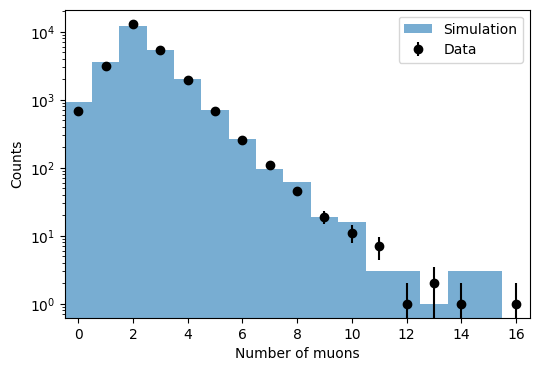

In [29]:
# use matplotlib to plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

# fill the histogram with the simulation (mc)
mc_counts = num_muons_dist.loc[num_muons_dist['sample']=='mc']
plt.bar(
    mc_counts['nMuon'], mc_counts['count'],
    label = 'Simulation', width=1, alpha=0.6
)

# use an errorbar plot to overlay data
# the error is the square root of the counts
data_counts = num_muons_dist.loc[num_muons_dist['sample']=='data']
plt.errorbar(
    data_counts['nMuon'],data_counts['count'],
    yerr = np.sqrt(data_counts['count']),
    label = 'Data', color='black', fmt='o'
)
plt.xlim(-0.5,16.5)
plt.xlabel("Number of muons")
plt.ylabel("Counts")
plt.legend()
plt.semilogy();

#### Step 2 - Filter and flatten the dataset

The end goal of this task is to study dimuon events, i.e. events/records having exactly 2 muons. 

Selecting such records is a simple filtering task, that can be performed in a variety of ways using the Spark DataFrame API:
- `pandas`-like selections, e.g. `df[df.column > xyz]`
- `where` or `filter` Spark DataFrame operations, analogous to the `filter` se used with RDDs
- fully-fledged `SQL` statements

`pandas`-like selections do work similarly to their pandas counterparts by operating on columns of the DataFrame:

```python
df[df.column > xyz]
```

In [30]:
# select only events with two muons
dimuon_df = df[df['nMuon']==2]

# print the first 5 rows
dimuon_df.show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



Also `where`/`filter` operations work similarly to the equivalent `pandas` logic.
The two are aliases of the same function (specifically `where` is an alias of `filter`) therefore there is no difference in writing one or the other.

We have already used `filter` on plain RDDs writing a Python function to apply to arbitrary data.

Using `where`/`filter` with DataFrames and having it operate on all items of a given column is, in principle, a slightly different concept.

Spark has to "understand" that we are working with a columnar object, and not with a plain collection of arbitrary data.
This is what we refer to when we say that we have low-level APIs and high-level APIs. From the user's point of view, the method call is going to be the same, but the underlying "wiring" of the function is different (we are offered a similar _interface_ to different _inner functions_ in the two cases).

We can write the same where/filter function in multiple ways:
- specifying that we are operating on a column named `column`
```python
df.where(col('column')>xyz)
```
- recalling the column from the DataFrame 
```python
df.where(df['column']>xyz)
```
- using the column name in the filter field
```python
df.where("column > xyz")
```

In [31]:
# import the column object from pyspark
from pyspark.sql.functions import col

# apply where explicitely on the spark column object
df.where(col('nMuon')==2)\
  .show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



In [32]:
# apply where recalling the column from the dataframe
df.where(df['nMuon']==2)\
  .show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



In [33]:
# apply where (or filter) using the column name in the filter field
df.filter("nMuon == 2")\
  .show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



Spark DataFrame has an underlying optimization engine for structured filters based on SQL.

In dealing with structured data, a common use case is to use Spark to interface with SQL:
- use SQL statements to query large and possibly distributed structured datasets
- connect to a remote SQL database and process data in parallel
- preprocess large amounts of raw data and then translate them into tables of a DB for data management
- ...

In PySpark using the structured data API (actually named `pyspark.sql` as we have seen) we can create a table _view_ from our dataset, and then use plain SQL code to run the same filters or aggregations.

The underlying scheduling and task optimization of Spark is always going to be there and will help execute queries and data filters quickly and efficiently.

In [34]:
# create a temporary table view of the dataframe 
# this will allow spark to execute SQL queries on the dataframe
# treating the dataframe as a table in a RDBMS
df.createOrReplaceTempView("dimuon_df_table")

# select all rows from the table
# where the number of muons is 2
spark.sql("""
          SELECT * FROM dimuon_df_table 
          WHERE nMuon = 2
          """)\
     .show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



After filtering the dataset and retaining only the data we want, we can start accessing the features and producing higher-level quantities and results.

However, at this stage, the Dataset is not flat, as we have nested content in the Muons column. 

In [35]:
# print the dataframe schema
dimuon_df.printSchema()

root
 |-- Muons: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- E: double (nullable = true)
 |    |    |-- charge: long (nullable = true)
 |    |    |-- px: double (nullable = true)
 |    |    |-- py: double (nullable = true)
 |    |    |-- pz: double (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- sample: string (nullable = true)



We can flatten our dataset for further processing: in this way, we will be able to perform operations between columns as in a "normal" `pandas` DataFrame.

A new column can be created by using `withColumn(name, func)` where :
- `name` is the name to be assigned to the new column
- `func` is a function taking as input one or more columns

For instance, a function may be to multiply together values in different columns, or simply copy the elements of a nested structure into a plain column.

However, any arbitrary complex function can be used to produce new columns: later we will define arbitrary **User Defined Functions (UDFs)** that will be applied to every row of the DataFrame.

To refine our selection by retaining only a subset of columns, we can use the `select` statement, similar to the `SELECT` SQL keyword.

On top of this, we can also drop all unused columns from the dataset with the `drop` function of the DataFrame.

To recap:
- `select()` projects a set of expressions and returns a new DataFrame
- `withColumn()` creates a new attribute from the given column
- `drop()` removes columns from the table

In [36]:
# starting from the dimuon dataframe (the filtered one)
dimuon_flat = (
    # select only the columns we need for the analysis
    dimuon_df.select([col('sample'), col('nMuon'), col('Muons')[0], col('Muons')[1]])
    # and then flatten the Muons array into one column per feature:
    #  - Energy                E
    #  - Momentum along x-axis px
    #  - Momentum along y-axis py
    #  - Momentum along a-axis pz
    #  - Charge                c
    .withColumn('E1', col('Muons[0].E'))
    .withColumn('px1', col('Muons[0].px'))
    .withColumn('py1', col('Muons[0].py'))
    .withColumn('pz1', col('Muons[0].pz'))
    .withColumn('c1',  col('Muons[0].charge'))
    .withColumn('E2',  col('Muons[1].E'))
    .withColumn('px2', col('Muons[1].px'))
    .withColumn('py2', col('Muons[1].py'))
    .withColumn('pz2', col('Muons[1].pz'))
    .withColumn('c2',  col('Muons[1].charge'))
    # drop the two Muons nested structures
    .drop('Muons[0]', 'Muons[1]')
)

# print the schema of the new dataframe
dimuon_flat.printSchema()

root
 |-- sample: string (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- E1: double (nullable = true)
 |-- px1: double (nullable = true)
 |-- py1: double (nullable = true)
 |-- pz1: double (nullable = true)
 |-- c1: long (nullable = true)
 |-- E2: double (nullable = true)
 |-- px2: double (nullable = true)
 |-- py2: double (nullable = true)
 |-- pz2: double (nullable = true)
 |-- c2: long (nullable = true)



#### Step 3 - Computing new features

At this stage, we are left with pairs of muons with flat data structures.

We would like to select only those pairs of muons with opposite electric charge and compute the invariant mass from the four-momenta of the two selected particles.

This is a relativistic invariant property that resonates around a given value in the case the two muons are produced by the decay of a "parent particle".

In [37]:
# starting from the flat dimuon dataset
# select only the pairs with opposite charge
dimuon_flat = dimuon_flat.where(col('c1')!=col('c2'))

# count the number of opposite-charge pairs
dimuon_flat.count()

18827

To compute the invariant mass of the two candidate muons we need first to compute the four-momentum of the parent particle 

$
\begin{align}
p &= \left(E_1+E_2,\quad p_{x,1}+p_{x,2},\quad p_{y,1}+p_{y,2},\quad p_{z,1}+p_{z,2}\right) = \\
  &= \left(E,\;p_x,\;p_y,\;p_z\right)=\\
  &= \left(E,\;\mathbf{p}\right)
\end{align}
$

Create four new columns in the DataFrame, one per each of the four coordinates: $(E,~px,~py,~pz)$

In [38]:
# create four new columns for the four components of the momentum
# and add them to the dataframe
dimuon_flat = dimuon_flat.withColumn('E', col('E1')+col('E2'))\
                         .withColumn('px', col('px1')+col('px2'))\
                         .withColumn('py', col('py1')+col('py2'))\
                         .withColumn('pz', col('pz1')+col('pz2'))

From the 4-momentum of the candidate, we can compute the invariant mass as

$
\begin{align}
M &= \sqrt{p\cdot p} =  \sqrt{(E^2 - \|\mathbf{p}\|^2)} =&\\
  &= \sqrt{E^2 - (px^2 + py^2 + pz^2)}
\end{align}
$

We can compute it by manipulating directly the columns of the DataFrame.

In [39]:
# compute the invariant mass

# import the spark sqrt function 
from pyspark.sql.functions import sqrt

# create a new column for the invariant mass
dimuon_flat = dimuon_flat.withColumn('M', 
                                     sqrt( col('E')*col('E') - 
                                     (col('px')*col('px')+
                                      col('py')*col('py')+
                                      col('pz')*col('pz'))
                                    )
)

# persist the dataframe after these new columns have been added
dimuon_flat = dimuon_flat.persist()

# show the first 5 values of the M column of the dataframe
dimuon_flat.select('M').show(5)

+------------------+
|                 M|
+------------------+
|27.915489438238453|
|113.64685563213851|
| 1.587766097105187|
|23.723239249480446|
|0.7389114718977652|
+------------------+
only showing top 5 rows



As we have anticipated, we can define custom functions and use them to evaluate complex features from the columns of our DataFrame.

A User Defined Function (UDF) is any arbitrary Python function that can be evaluated by Spark on any row of your DataFrame.
If there is any risk a UDF might fail (e.g. if the value of a column is `None`) you must remember to protect the function (e.g. by adding an `if _ is not None` condition).

- PySpark UDFs are extremely useful when **there is no native Spark function available for the computation you need to perform**.
- They are also a nice way of writing **simple Python code** and letting Spark run it on the data stored in the partitions.
- We can easily **write and reuse complex functions** in multiple occurrences in our distributed computation.

***BUT...*** the PySpark UDFs are custom Python code executed on Java VMs (the executors)...
Spark will thus have to start Python processes on the executors, execute the function row by row on that data in the Python process, and then finally return the results of the row operations to the JVM and Spark.
**This typically takes a toll on the performances**

In [40]:
# create a pyspark udf
from pyspark.sql.functions import udf
import math

# create a function that takes in four columns and returns a float
# this is the function that will be used as the udf
@udf('float')
def invariant_mass(E, px, py, pz):
    # the function evaluates plain python code 
    # no vectorization (numpy) is involved
    return math.sqrt(E*E - (px*px + py*py + pz*pz))

# apply the udf to the appropriate columns
# and return the first 5 rows
dimuon_flat.select(
    invariant_mass(col('E'), col('px'), col('py'), col('pz'))
).show(5)

+-----------------------------+
|invariant_mass(E, px, py, pz)|
+-----------------------------+
|                     27.91549|
|                    113.64686|
|                     1.587766|
|                     23.72324|
|                   0.73891145|
+-----------------------------+
only showing top 5 rows



To partially overcome the performance issues, we can use **Pandas UDFs in PySpark**, also referred to as **vectorized UDFs**.

This allows to processing PySpark's DataFrames and columns as Pandas DataDrames and Pandas series, respectively.

Differently from the standard UDFs, these Pandas UDFs perform the same operation on the entire pandas series (vectorized operation) and do not run one row at a time.

This provides a boost in the efficiency of the computation and thus should be preferred whenever there is the possibility.

They result particularly efficient in the "grouped maps", i.e. by applying a user-defined function after a `groupby` to perform dedicated aggregation on the data. 

More on this can be found [here](https://spark.apache.org/docs/latest/api/python/user_guide/sql/arrow_pandas.html#pandas-udfs-a-k-a-vectorized-udfs) and [here](https://spark.apache.org/docs/latest/api/python/user_guide/sql/arrow_pandas.html#grouped-map). 

In [41]:
# create a pyspark pandas udf
from pyspark.sql.functions import pandas_udf

# the pandas udf takes four pandas series
# and returns a pandas series (a single column)
@pandas_udf('float')
def invariant_mass_udf(
    # the four input pandas series (with explitic type definition)
    E: pd.Series,
    px: pd.Series,
    py: pd.Series,
    pz: pd.Series
) -> pd.Series:
    # the resulting pandas series (a numpy array)
    # once again with the explicit type definition
    return np.sqrt(E*E - (px*px + py*py + pz*pz))

# apply the pandas udf to the appropriate columns
# and return the first 5 rows
#
# we can also use an alias to rename the column
dimuon_flat.select(
    invariant_mass_udf(col('E'), col('px'), col('py'), col('pz')).alias('M pandas udf')
).show(5)


+------------+
|M pandas udf|
+------------+
|    27.91549|
|   113.64686|
|    1.587766|
|    23.72324|
|  0.73891145|
+------------+
only showing top 5 rows



Compute the average energy $E$ of the muons found in each of the two `sample` groups.

To do this, compare the two approaches:
1. use only PySpark native functions to run groupBy and aggregations (look up [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/grouping.html) about all the available built-in aggregations)
2. use a vectorized UDF to evaluate the average for each group

Use only PySpark native functions to run groupBy and aggregations

In [42]:
# compute the mean energy for muons in each 
# sample using pyspark native functions
dimuon_flat.select(col('sample'), col('E'))\
           .groupBy('sample')\
           .mean()\
           .show()

+------+-----------------+
|sample|           avg(E)|
+------+-----------------+
|    mc|77.57125860575748|
|  data|81.11666603913983|
+------+-----------------+



Use a vectorized-UDF to run the aggregation

In [43]:
# compute the mean energy for muons in each 
# sample using a pyspark vectorized udf function
@pandas_udf('float')
def mean_udf(v: pd.Series) -> float:
    return v.mean()

dimuon_flat.select(col('sample'), col('E'))\
           .groupBy('sample')\
           .agg(mean_udf(col('E')))\
           .show()

+------+-----------+
|sample|mean_udf(E)|
+------+-----------+
|  data|   81.11667|
|    mc|   77.57126|
+------+-----------+



#### Step 4 - (Re-)Discovering particles

Now that we have loaded our dataset in the cluster, inspected it, pre-processed it by selecting and flattening variables, and we have computed all the high-level quantities, we can finally use the dataset to perform the final analysis.

For example, let's plot the invariant mass $M$ of the dimuon system in its whole range.

In [44]:
# compute the histogram of M
# 
# 1. select the M column
# 2. get the underlying RDD
# 3. retrieve the M values into a histogram 
#    (remember the .histogram() RDD function from the previous notebook)
# 
# - use 0-150 GeV as the histogram range
# - use 2 GeV as the bin width

range_min = 0
range_max = 150
bin_width = 2

bins, counts = dimuon_flat.select('M')\
                          .rdd\
                          .histogram(list(np.arange(range_min,range_max,bin_width)))    

# print the bins and counts to check the logic
print(bins, counts)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148] [2868, 3217, 392, 392, 546, 382, 252, 252, 245, 283, 375, 474, 531, 567, 538, 450, 398, 342, 301, 255, 248, 195, 195, 153, 138, 110, 112, 102, 80, 82, 67, 66, 58, 48, 59, 52, 54, 56, 63, 74, 83, 102, 181, 336, 716, 1026, 613, 241, 123, 54, 59, 31, 16, 17, 12, 6, 14, 12, 11, 7, 3, 3, 6, 3, 5, 5, 3, 3, 1, 7, 1, 1, 5, 1]


In [45]:
# create two histograms, one per sample (data/mc)

# it could be convenient to use a dictionary 
# to host the two samples' bins and counts
histogram_results = {}

# perform the same pyspark function on both samples
for sample in ['mc', 'data']:
    histogram_results[sample] = {}
    
    bins, counts = dimuon_flat.where(col('sample')==sample)\
                              .select('M')\
                              .rdd\
                              .histogram(list(np.arange(range_min,range_max,bin_width)))    
    
    histogram_results[sample]['bins'] = bins
    histogram_results[sample]['counts'] = counts

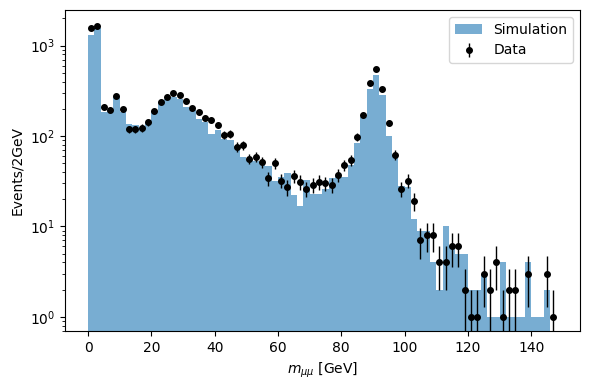

In [46]:
# create a plot containing
# - a filled histogram for the Simulation (mc)
# - an errorbar plot for the Data (data), with sqrt(count) as the y-error
# - show the resulting plot in semi-log scale
plt.figure(figsize=(6,4))

mc_res = histogram_results['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(bin_centers, 
         weights=mc_res['counts'], 
         bins=mc_res['bins'],
         label='Simulation', 
         alpha=0.6
)

data_res = histogram_results['data']
bin_centers = data_res['bins'][:-1] + np.diff(data_res['bins'])/2
plt.errorbar(
    bin_centers, 
    data_res['counts'], 
    yerr=np.sqrt(data_res['counts']),
    fmt='o', 
    ms=4, 
    lw=1, 
    color='black', 
    label='Data'
)

plt.xlabel("$m_{\mu \mu}$ [GeV]")
plt.ylabel(f"Events/{bin_width}GeV")
plt.legend()
plt.semilogy()
plt.tight_layout();

The plot shows a number of features we are not going to talk about in this class.

However, to complete the exercise, we'll focus on the range 75-115 GeV, where it appears to be a large resonance.

We can create a new plot of data and simulations in that specific range with higher binning "resolution" (0.5 GeV), to study how well the simulation agrees with the experimental data.

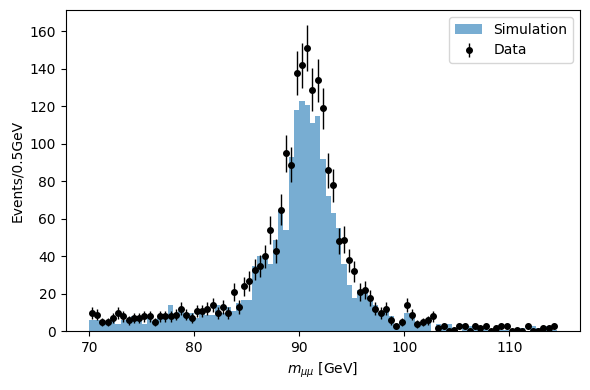

In [47]:
# create a plot containing
# - a filled histogram for the Simulation (mc)
# - an errorbar plot for the Data (data), with sqrt(count) as the y-error
# - show the resulting plot in semi-log scale
histogram_results = {}
for sample in ['mc', 'data']:
    histogram_results[sample] = {}
    
    bins, counts = dimuon_flat.where(col('sample')==sample)\
                              .select('M')\
                              .rdd\
                              .histogram(list(np.arange(70,115,0.5)))
    
    histogram_results[sample]['bins'] = bins
    histogram_results[sample]['counts'] = counts
    
plt.figure(figsize=(6,4))

mc_res = histogram_results['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(bin_centers, 
         weights=mc_res['counts'], 
         bins=mc_res['bins'],
         label='Simulation', 
         alpha=0.6
)

data_res = histogram_results['data']
bin_centers = data_res['bins'][:-1] + np.diff(data_res['bins'])/2
plt.errorbar(
    bin_centers, 
    data_res['counts'], 
    yerr=np.sqrt(data_res['counts']),
    fmt='o', 
    ms=4, 
    lw=1, 
    color='black', 
    label='Data'
)

plt.xlabel("$m_{\mu \mu}$ [GeV]")
plt.ylabel(f"Events/0.5GeV")
plt.legend()
plt.tight_layout();

We can try to perform some selections, to improve the quality of the signal and remove the background, and hopefully this selection might help restore a decent Data-Simulation agreement.

To do this we can try to look at dimuon candidates with a large transverse momentum 

$
\begin{align}
p_T &= \sqrt{p_x^2 + p_y^2} = \\
    &= \sqrt{(p_{x,1}+p_{x,2})^2 + (p_{y,1}+p_{y,2})^2}
\end{align}
$

- Create a column with name `highpt` and for each row set the value to `True` if $p_T\geq 30$ Gev and `False` otherwise
    - Start from the two muons and use a UDF for this
    - Use the PySpark `when` and `otherwise` function (have a look at the documentation [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.otherwise.html))
- Plot the Data-Simulation comparison for dimuon candidates passing the `highpt` selection

In [48]:
# create the udf to evaluate the dimuon pT

# @udf('float')
# def candidate_pt(px1, py1, px2, py2):
#     return math.sqrt( (px1+px2)**2 + (py1+py2)**2)

@pandas_udf('float')
def candidate_pt(px1: pd.Series,
                 px2: pd.Series,
                 py1: pd.Series,
                 py2: pd.Series) -> pd.Series:
    return np.hypot(px1+px2,py1+py2)

In [49]:
# apply the udf to the dimuon_flat dataframe
dimuon_flat = dimuon_flat.withColumn("pT",
                                     candidate_pt(col('px1'),col('py1'),col('px2'),col('py2')))

In [50]:
# import the when function from pyspark.sql
from pyspark.sql.functions import when

# create the `highpt` feature with where/otherwise
dimuon_flat = dimuon_flat.withColumn("highpt", 
                                     when(dimuon_flat.pT>30, True).otherwise(False))

In [51]:
# inspect a few rows of the dataframe 
# to verify the feature is set correctly
dimuon_flat['sample','M','pT','highpt'].show(5)

+------+------------------+----------+------+
|sample|                 M|        pT|highpt|
+------+------------------+----------+------+
|  data|27.915489438238453|  8.415339| false|
|  data|113.64685563213851| 73.245346|  true|
|  data| 1.587766097105187|  36.89738|  true|
|  data|23.723239249480446| 23.844759| false|
|  data|0.7389114718977652|11.7450285| false|
+------+------------------+----------+------+
only showing top 5 rows



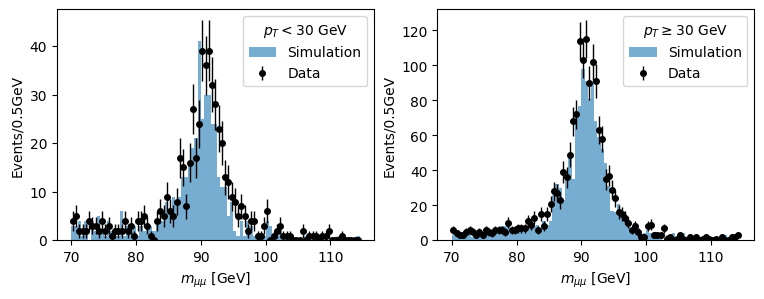

In [52]:
# create the two data-simulation comparison plots
# for low- and high-pt dimuon candidate
def compute_histogram(dataset, column):
    histogram_results = {}
    for sample in ['mc', 'data']:
        histogram_results[sample] = {}

        bins, counts = dataset.where(col('sample')==sample)\
                              .select(column)\
                              .rdd\
                              .histogram(list(np.arange(70,115,0.5)))

        histogram_results[sample]['bins'] = bins
        histogram_results[sample]['counts'] = counts
        
    return histogram_results        

high_pt_candidates = compute_histogram(dimuon_flat.where('highpt==True'),  'M')
low_pt_candidates  = compute_histogram(dimuon_flat.where('highpt==False'), 'M')
 
# create a common figure    
fig, axs = plt.subplots(1, 2, figsize=(9,3))

# low-pt candidates
low_pt_mc = low_pt_candidates['mc']
bin_centers = low_pt_mc['bins'][:-1] + np.diff(low_pt_mc['bins'])/2
axs[0].hist(bin_centers, 
            weights=low_pt_mc['counts'], 
            bins=low_pt_mc['bins'],
            label='Simulation', 
            alpha=0.6
)

low_pt_data = low_pt_candidates['data']
bin_centers = low_pt_data['bins'][:-1] + np.diff(low_pt_data['bins'])/2
axs[0].errorbar(
       bin_centers, 
       low_pt_data['counts'], 
       yerr=np.sqrt(low_pt_data['counts']),
       fmt='o', 
       ms=4, 
       lw=1, 
       color='black', 
       label='Data'
)

axs[0].set_xlabel("$m_{\mu \mu}$ [GeV]")
axs[0].set_ylabel(f"Events/0.5GeV")
axs[0].legend(title=r'$p_T < 30$ GeV')

# high-pt candidates
high_pt_mc = high_pt_candidates['mc']
bin_centers = high_pt_mc['bins'][:-1] + np.diff(high_pt_mc['bins'])/2
axs[1].hist(bin_centers, 
            weights=high_pt_mc['counts'], 
            bins=high_pt_mc['bins'],
            label='Simulation', 
            alpha=0.6
)

high_pt_data = high_pt_candidates['data']
bin_centers = high_pt_data['bins'][:-1] + np.diff(high_pt_data['bins'])/2
axs[1].errorbar(
       bin_centers, 
       high_pt_data['counts'], 
       yerr=np.sqrt(high_pt_data['counts']),
       fmt='o', 
       ms=4, 
       lw=1, 
       color='black', 
       label='Data'
)

axs[1].set_xlabel("$m_{\mu \mu}$ [GeV]")
axs[1].set_ylabel(f"Events/0.5GeV")
axs[1].legend(title=r'$p_T \geq 30$ GeV');

## Stop worker and master

In [54]:
sc.stop()
spark.stop()

Finally, use `docker compose down` to stop and clear all running containers.